In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# import basic plot tools
from qiskit.visualization import plot_histogram

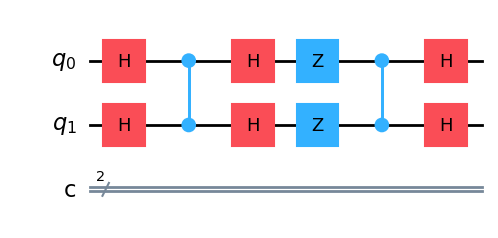

In [19]:
grover_circuit = QuantumCircuit(2, 2)
grover_circuit.h([0,1])

grover_circuit.cz(0,1)

grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])

grover_circuit.draw()

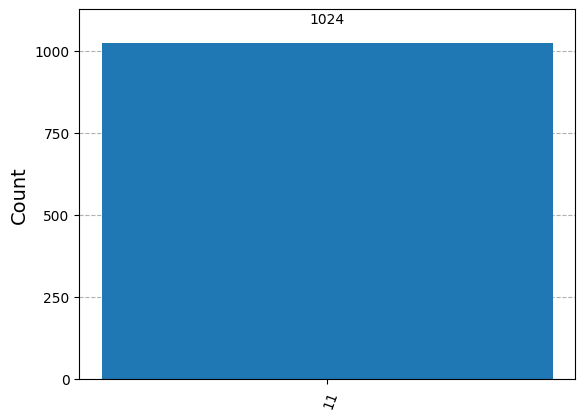

In [37]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
grover_circuit.measure([0,1], [0,1])
result = sim.run([grover_circuit], shots = 1024).result()
counts = result.get_counts(grover_circuit)
plot_histogram(counts)

In [38]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

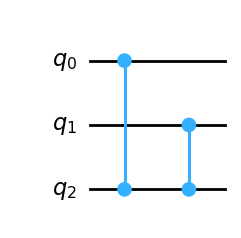

In [40]:
qc.draw()

In [44]:
from qiskit.circuit.library import MCXGate, MCMT
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.append(MCXGate(nqubits - 1), list(range(nqubits - 1)) + [nqubits - 1])
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

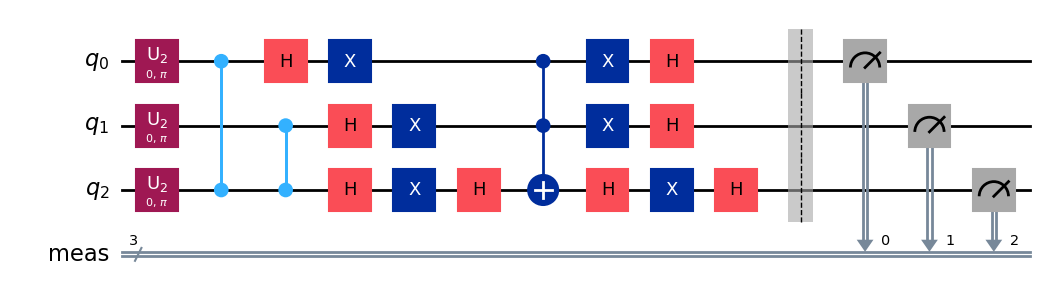

In [70]:

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.decompose().draw()

In [73]:
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler

sim = AerSimulator()
sampler = Sampler()
result = sampler.run(grover_circuit).result()
print(result)


SamplerResult(quasi_dists=[{5: 0.499999999999999, 6: 0.499999999999999}], metadata=[{}])


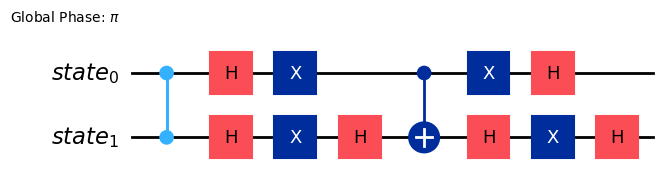

In [74]:
from qiskit import QuantumCircuit
from qiskit_algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ["11"]

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
# (Algorithm circuits are wrapped in a gate to appear in composition as a block
# so we have to decompose() the op to see it expanded into its component gates.)
problem.grover_operator.decompose().draw(output="mpl")

In [75]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)




Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


In [76]:
from qiskit.quantum_info import Statevector

oracle = Statevector.from_label("111")
problem = AmplificationProblem(oracle, is_good_state=["111"])

grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Result type:", type(result))
print()
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)


Result type: <class 'qiskit_algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 111


In [105]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError

# `Oracle` (`PhaseOracle`) as the `oracle` argument
expression = "(a & b)"
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle)
    display(problem.grover_operator.oracle.decompose().draw(output="mpl"))
except MissingOptionalLibraryError as ex:
    print(ex)
    

"The 'tweedledum' library is required to use 'PhaseOracle'. You can install it with 'pip install tweedledum'."


In [96]:
import tweedledum
print("tweedledum version:", tweedledum.phase_oracle(11))

tweedledum version: None


In [109]:
import numpy as np

# Specifying `state_preparation`
# to prepare a superposition of |01>, |10>, and |11>
oracle = QuantumCircuit(3)
oracle.ccz(0, 1, 2)

theta = 2 * np.arccos(1 / np.sqrt(3))
state_preparation = QuantumCircuit(3)
state_preparation.ry(theta, 0)
state_preparation.ch(0, 1)
state_preparation.x(1)
state_preparation.h(2)


state preparation circuit:


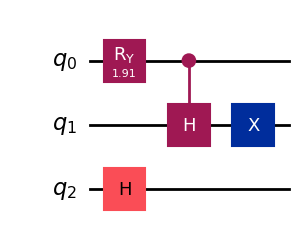

In [107]:
# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(
    oracle, state_preparation=state_preparation, is_good_state=["110", "111"]
)

# state_preparation
print("state preparation circuit:")
problem.grover_operator.state_preparation.draw(output="mpl")

In [113]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)

Success!
Top measurement: 111


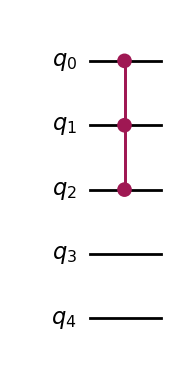

In [114]:
oracle = QuantumCircuit(5)
oracle.ccz(0, 1, 2)
oracle.draw(output="mpl")

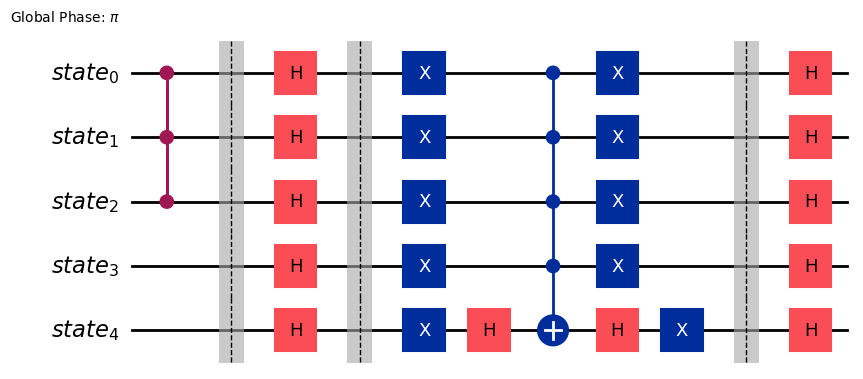

In [115]:
from qiskit.circuit.library import GroverOperator

grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw(output="mpl")

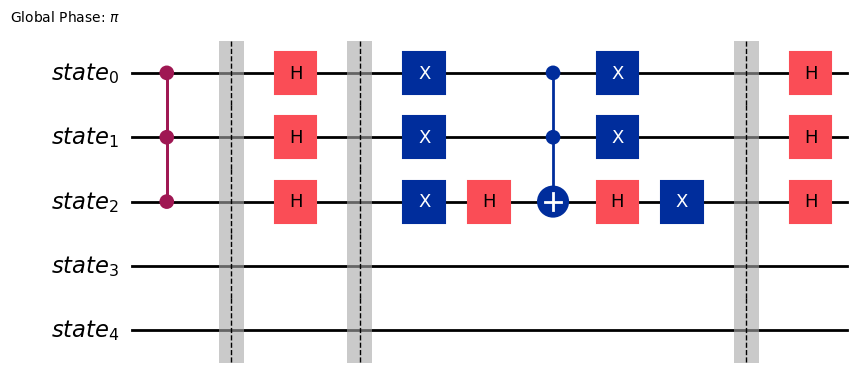

In [116]:
grover_op = GroverOperator(oracle, reflection_qubits=[0, 1, 2], insert_barriers=True)
grover_op.decompose().draw(output="mpl")

In [121]:
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = ["11", "00"]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("01"))
print(problem.objective_qubits)

False
[0, 1]


In [120]:
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = [0, 1]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state("11"))
print(problem.objective_qubits)

True
[0, 1]


In [128]:
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"])
grover = Grover(iterations=1, sampler=Sampler())
result = grover.amplify(problem)
print("Success!" if result.oracle_evaluation else "Failure!")
print("Top measurement:", result.top_measurement)
print(result.top_measurement)

Success!
Top measurement: 11
11


In [133]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=8)
iterations

12

In [134]:
def to_DIAMACS_CNF_format(bit_rep):
    return [index + 1 if val == 1 else -1 * (index + 1) for index, val in enumerate(bit_rep)]

In [135]:
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=["11"], post_processing=to_DIAMACS_CNF_format)
problem.post_processing([1, 0, 1])

[1, -2, 3]

In [136]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

NameError: name 'clause_list' is not defined

In [140]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [138]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
print(in_qubits)

QuantumRegister(2, 'input')


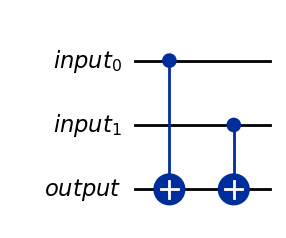

In [141]:
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output='mpl')

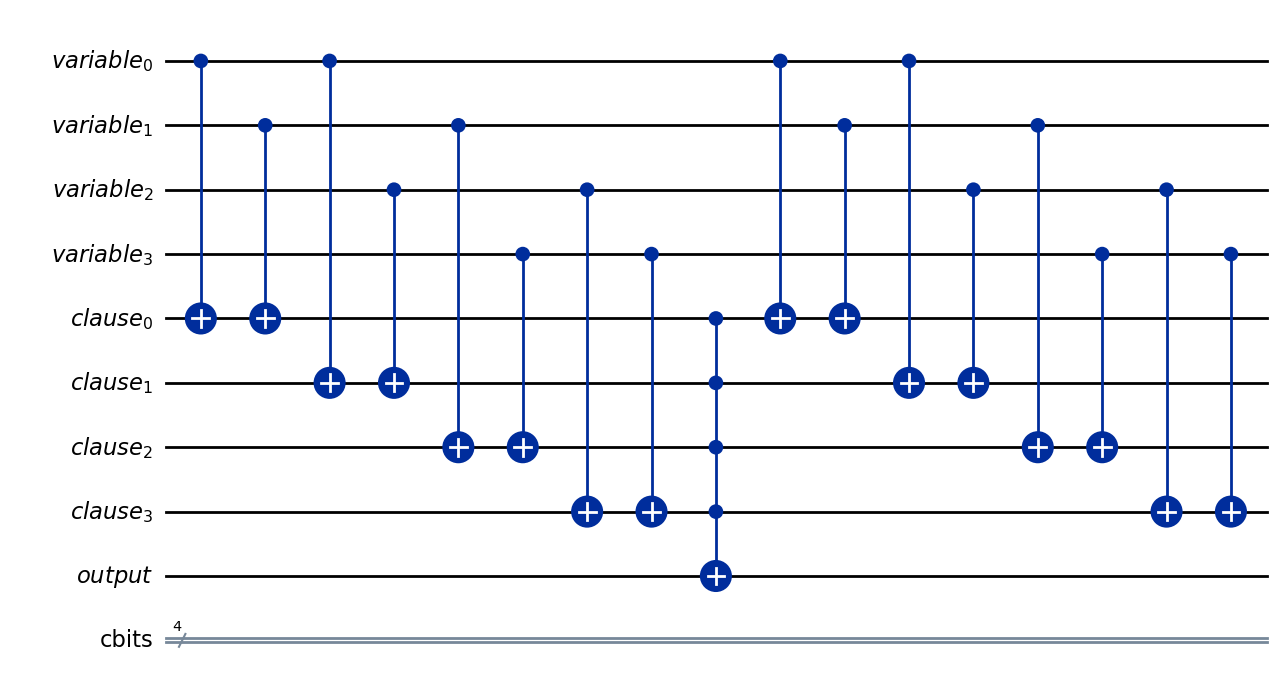

In [146]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

variable_qubits = QuantumRegister(4, name='variable')
clause_qubits = QuantumRegister(4, name='clause')
output_qubit = QuantumRegister(1, name='output')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(variable_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i+=1
    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)
    
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i+=1
        
sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw(output='mpl')

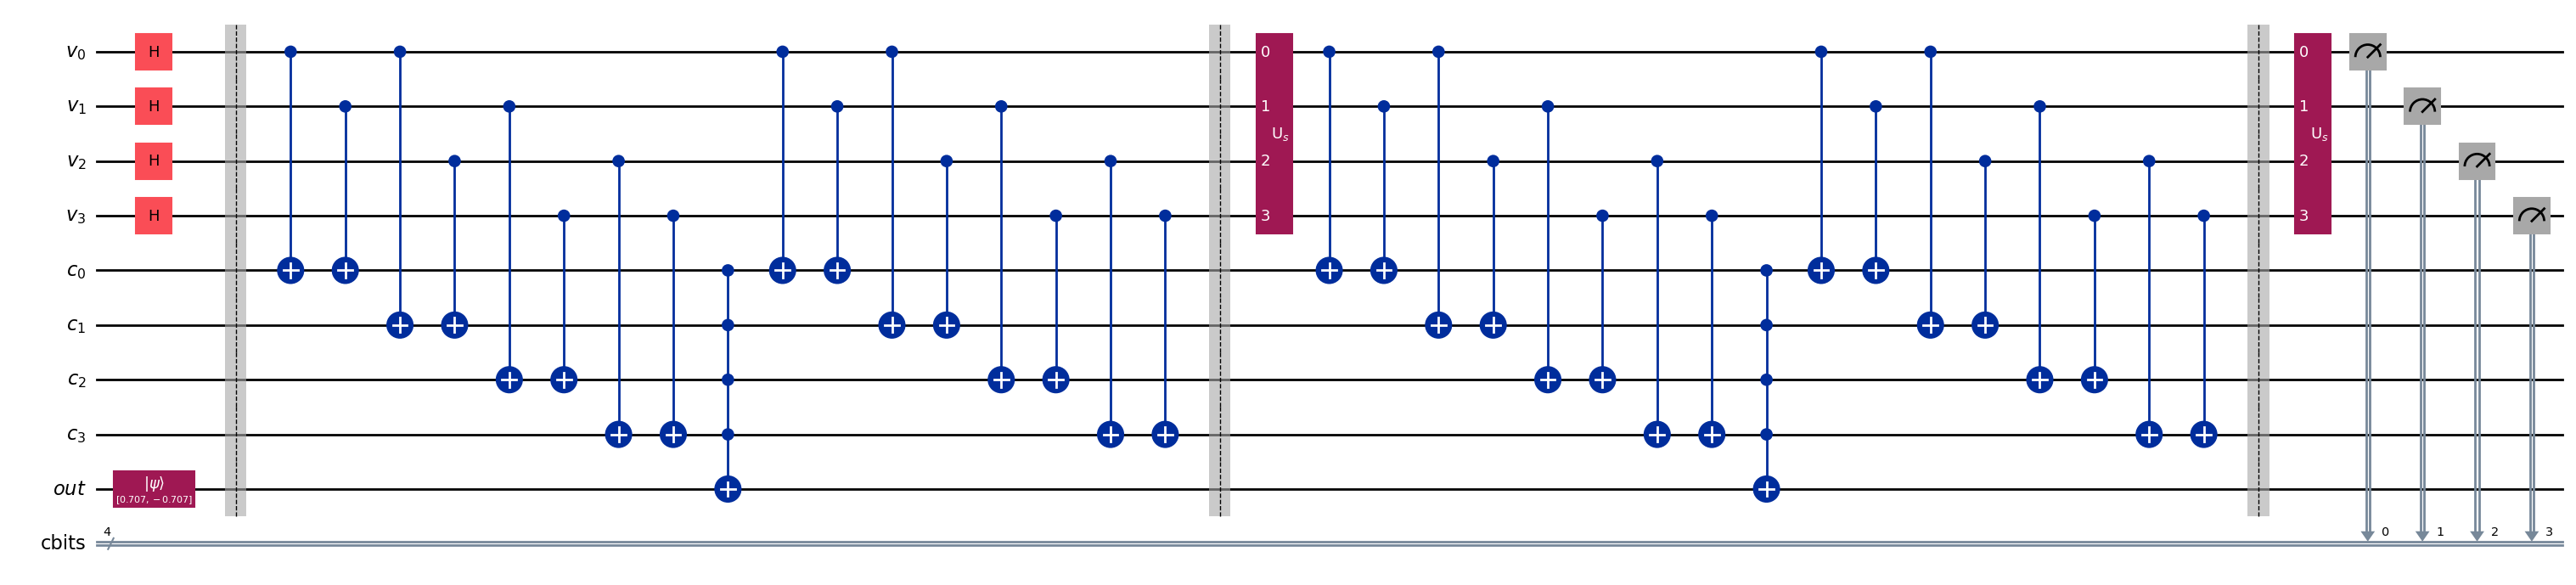

In [148]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

In [151]:
result = sampler.run(qc).result()
print(result)

SamplerResult(quasi_dists=[{0: 0.00390625, 1: 0.00390625, 2: 0.00390625, 3: 0.00390625, 4: 0.00390625, 5: 0.00390625, 6: 0.472656249999998, 7: 0.00390625, 8: 0.00390625, 9: 0.472656249999998, 10: 0.00390625, 11: 0.00390625, 12: 0.00390625, 13: 0.00390625, 14: 0.00390625, 15: 0.00390625}], metadata=[{}])


In [152]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
"""

In [165]:
!pip install tweedledum==0.1b0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.9 MB/s eta 0:00:00a 0:00:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tweedledum: filename=tweedledum-0.1b0-cp39-cp39-macosx_14_0_arm64.whl size=120900 sha256=782a546c0218fd247a5d04d40048c5b3b8840b98675cc2f6cfa1caaf075af8cb
  Stored in directory: /Users/mac/Library/Caches/pip/wheels/f8/e7/1e/e26472c74445c9324ae34c975c42392e484720828a52ff438b
Successfully built tweedledum
  Attempting uninstall: tweedledum
    Found existing installation: tweedledum 1.1.0
    Uninstalling tweedledum-1.1.0:
      Successfully uninstalled tweedledum-1.1.0


In [179]:
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit.library.phase_oracle import PhaseOracle

fp = tempfile.NamedTemporaryFile(mode="w+t", delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)

"The 'tweedledum' library is required to use 'BooleanExpression'. You can install it with 'pip install tweedledum'."


In [173]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

In [177]:
from qiskit_algorithms import Grover
from qiskit.primitives import Sampler

grover = Grover(sampler=Sampler())
result = None
if problem is not None:
    result = grover.amplify(problem)
    print(result.assignment)

if result is not None:
    display(plot_histogram(result.circuit_results[0]))

In [178]:
expression = '(w ^ x) & ~(y ^ z) & (x & y & z)'
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
    grover = Grover(sampler=Sampler())
    result = grover.amplify(problem)
    display(plot_histogram(result.circuit_results[0]))
except MissingOptionalLibraryError as ex:
    print(ex)

"The 'tweedledum' library is required to use 'PhaseOracle'. You can install it with 'pip install tweedledum'."


In [180]:
def is_satisfiable(cnf_formula, assignment):
    """
    Check if the current assignment satisfies the CNF formula.
    """
    for clause in cnf_formula:
        satisfied = False
        for literal in clause:
            var = abs(literal)
            if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                satisfied = True
                break
        if not satisfied:
            return False
    return True

def solve_cnf(cnf_formula, num_vars, assignment=None, var=1):
    """
    Solve the CNF SAT problem using a backtracking approach.
    """
    if assignment is None:
        assignment = [None] * (num_vars + 1)

    if var > num_vars:
        if is_satisfiable(cnf_formula, assignment):
            return assignment
        return None

    # Try assigning True to the current variable
    assignment[var] = True
    result = solve_cnf(cnf_formula, num_vars, assignment, var + 1)
    if result:
        return result

    # Try assigning False to the current variable
    assignment[var] = False
    result = solve_cnf(cnf_formula, num_vars, assignment, var + 1)
    if result:
        return result

    return None

# Example usage
if __name__ == "__main__":
    # CNF formula represented as a list of clauses, where each clause is a list of literals
    # Example: (x1 OR ~x2) AND (x2 OR x3 OR ~x1)
    cnf_formula = [
        [1, -2],
        [2, 3, -1]
    ]

    num_vars = 3  # Number of variables in the formula

    result = solve_cnf(cnf_formula, num_vars)
    if result:
        print("Satisfiable assignment found:")
        for i in range(1, num_vars + 1):
            print(f"x{i} = {result[i]}")
    else:
        print("No satisfiable assignment exists.")

Satisfiable assignment found:
x1 = True
x2 = True
x3 = True
